This function takes in a list of blobs as x and y coordinates.
It tries to construct likely graphs connecting the blobs in a way that the match a pattern that could have been created by the electrodes. Each graph is assigned a likelyhood, and the best graph is returned.

In [232]:
np.min(variances)

56.010975450229374

In [238]:
new = [i * .1 for i in compactness]

In [211]:
np.add(variances, np.multiply(0.1* compactness))

TypeError: can't multiply sequence by non-int of type 'float'

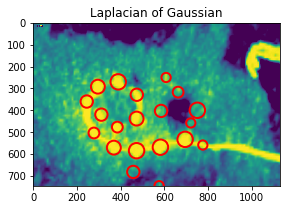

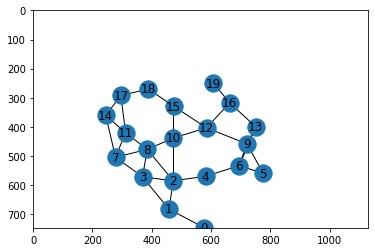

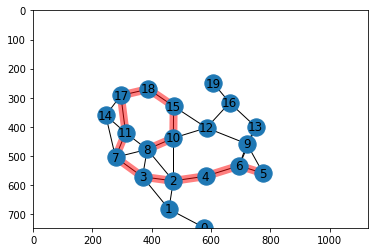

In [248]:
from functions import *
import itertools
import networkx as nx
allpost, allpre, basenames = load("DATA")
blobs = get_blobs(allpost[11],20)

max_angle=50
angle_r=180-max_angle
angle_l=180+max_angle

graph = nx.Graph()
graph.add_nodes_from(dict(enumerate(blobs)))

pos = {}
for i,blob in enumerate(blobs):
    graph.nodes[i]['pos'] = (blob[0],blob[1])
    pos.update({i:(blob[1],blob[0])})

#pairwise_combinations = list(itertools.combinations(blobs, 2))
pairwise_combinations = list(itertools.combinations(range(len(blobs)), 2))
for i, j in pairwise_combinations:
    blob_a = blobs[i]
    blob_b = blobs[j]
    dist = blob_dist(blob_a, blob_b)
    #if dist < 170 and dist > 90:
    if dist < 150 and dist > 60:
        graph.add_edge(i, j, length=dist)

        
draw_graph(graph,pos)
graph = remove_unconnected(graph)
#draw_graph(graph,pos)

paths = []

for node in graph.nodes():
    for neighbor in graph.neighbors(node):
        start = [node,neighbor]
        graph_new = graph.copy()
        graph_new.remove_node(node)
        solutions = get_next_possible_neigbours(graph, graph_new, start)
        for solution in solutions:
                paths.append(solution)

#start = [5,2]
#graph_new = graph.copy()
#graph_new.remove_node(5)
#draw_graph(graph_new,pos)

#paths = get_next_possible_neigbours(graph, graph_new, start)
variances = [dist_var_of_path(blobs, path) for path in paths]
compactness = [2*path_compactness(blobs, path) for path in paths]

new = [i * .1 for i in compactness]
likelihood = np.add(variances,new)
path = paths[np.argmin(likelihood)]
path = paths[np.argmin(variances)]
draw_graph_path(graph,pos,path)

In [236]:
def get_next_possible_neigbours(graph_full, graph_left, path_chosen):
    #graph_full: the whole graph
    #graph_left: the part of the graph that is still available
    #path_chosen: list of nodes that make up this path: [starting node, ... , end node]
    if len(path_chosen)==12:
        #print(path_chosen)
        return [path_chosen]
    #[n for n in graph.neighbors(start[-1])]
    #print(path_chosen)
    paths_chosen = []
    #paths_chosen = path_chosen.copy()
    for neighbor in graph_left.neighbors(path_chosen[-1]):
        blob1 = blobs[neighbor,:]
        blob2 = blobs[path_chosen[-1],:]
        blob3 = blobs[path_chosen[-2],:]
        this_angle = blob_angle(blob1, blob2, blob3)
        if this_angle < 85:            
            #we've found a possible neighbor!
            new_graph_full = graph_full.copy()
            new_graph_left = graph_left.copy()
            new_graph_left.remove_node(path_chosen[-1])
            new_path_chosen = path_chosen.copy()
            new_path_chosen.append(neighbor)
            #call the function recursively with the updated path
            recursive_return = get_next_possible_neigbours(new_graph_full, new_graph_left, new_path_chosen)
            for solution in recursive_return:
                paths_chosen.append(solution)
    return paths_chosen
            

In [203]:
def path_compactness(blobs, path):
    coordinates = blobs[path,0:2]
    x_mean = np.mean(coordinates[:,0])
    y_mean = np.mean(coordinates[:,1])
    distances = [distance((x_mean,y_mean), node) for node in coordinates]
    return np.sum(distances)

In [193]:
coordinates = blobs[path,0:2]


384.9166666666667

In [99]:
def dist_var_of_path(blobs, path):
    dists = []
    route_edges = [(path[n],path[n+1]) for n in range(len(path)-1)]
    for a,b in route_edges:
        dists.append(blob_dist(blobs[a,:],blobs[b,:]))
    return np.var(dists)    

In [235]:
blob1 = blobs[10,:]
blob2 = blobs[13,:]
blob3 = blobs[14,:]
blob_angle(blob1, blob2, blob3)
#[(path[n],path[n+1]) for n in range(len(path)-1)]

80.6181538606228

In [27]:
def remove_unconnected(graph):
    #removes subgraphs that have <12 nodes as they cannot be our electrodes
    components_generator = nx.connected_components(graph)
    components = [graph.subgraph(c).copy() for c in components_generator]
    for component in components:
        if len(component)<12:
            graph.remove_nodes_from(component.nodes)
    return graph
    #draw_graph(S[0],pos)

In [28]:
def draw_graph(graph,pos):
    ax = plt.figure().gca()
    ax.set_axis_on()
    ax.set_ylim([746,0])
    ax.set_xlim([0,1129])
    nx.draw_networkx(graph,pos, ax=ax)
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    #nx.draw_planar(graph)
    plt.show()

In [86]:
def draw_graph_path(graph,pos,path):
    route_edges = [(path[n],path[n+1]) for n in range(len(path)-1)]
    ax = plt.figure().gca()
    ax.set_axis_on()
    ax.set_ylim([746,0])
    ax.set_xlim([0,1129])
    nx.draw_networkx(graph,pos, ax=ax)
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    #nx.draw_planar(graph)
    nx.draw_networkx_edges(graph, pos,
                       edgelist=route_edges,
                       width=8, alpha=0.5, edge_color='red')
    plt.show()

In [29]:
def blob_angle(blob1, blob2, blob3):
    x1, y1, r = blob1
    x2, y2, r = blob2
    x3, y3, r = blob3    
    v1_x = x2 - x1
    v1_y = y2 - y1
    v2_x = x3 - x2
    v2_y = y3 - y2    
    return angle((v1_x,v1_y),(v2_x,v2_y))

In [30]:
def blobs_in_range(center, blobs, max_range):
    #check which blobs are inside of range
    blobs_in_range = []
    for i, blob in enumerate(blobs):
        if dist(center,blob)<= max_range:
            blobs_in_range.append(i)
    return blobs_in_range
        

In [31]:
def blob_dist(blob1, blob2):
    return distance(blob1[0:2], blob2[0:2])

In [245]:
def get_blobs (image,nb_blobs):
    from skimage.feature import blob_log
    #returns list of X,Y coordinates and approximate radii of blobs detected
    #removes blobs that are far away until only nb_blobs are left
    
    image_gray = rgb2gray(image)

    #preprocessing: contrast stretching
    p2, p98 = np.percentile(image_gray, (2, 98))
    image_gray = exposure.rescale_intensity(image_gray, in_range=(p2, p98))


    #blob detection
    blobs_log = blob_log(image_gray, min_sigma = 15, max_sigma=25, num_sigma=5, threshold=.12)

    # comp approximated radii in the 3rd col
    blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

    while len(blobs_log) > nb_blobs:
        distances = np.zeros((len(blobs_log), 2))
        for i, blob in enumerate(blobs_log):
            distances[i][0] = int(i)
            y1,x1,r = blob
            for n in range (i,len(blobs_log)):
                y2,x2, r = blobs_log[n]
                # draw.line((x1, y1, x2, y2), fill=128)
                dist = distance((x1,y1),(x2,y2))

                distances[i][1] += dist
                distances[n][1] += dist
        distances = distances[distances[:, 1].argsort()][:len(distances)]
        last = int(distances[len(distances)-1][0])
        #print(blobs_log)
        blobs_log = np.delete(blobs_log,last, axis=0)
        #print(blobs_log)
        #print(len(blobs_log))


    #display the blobs
    fig, ax = plt.subplots(1, 1, figsize=(9, 3), sharex=True, sharey=True)
    blobs = blobs_log
    title = 'Laplacian of Gaussian'
    ax.set_title(title)
    ax.imshow(image_gray)
    for blob in blobs_log:
        y, x, r = blob
        c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
        ax.add_patch(c)
    #ax.set_axis_off()
    plt.show()
    
    return blobs_log